# Part I : Quel(le) data scientist êtes-vous ?
## Contexte de l’analyse

Elu métier le plus sexy par la Harvard Business Review en octobre 2012, le data scientist représente un profil rare qui exige de nombreuses compétences.

A partir d'un dataset Aquila, vous réaliserez :
- un clustering non supervisé afin d'identifier 2 groupes de profils techniques distinctes
- une prédiction des profils dont le métier n'est pas labellisé


## Données
data.csv contient 6 variables : 
    - 'Entreprise' correspond à une liste d'entreprises fictive
    - 'Metier' correspond au métier parmi data scientist, lead data scientist, data engineer et data architecte
    - 'Technologies' correspond aux compétences maîtrisées par le profil
    - 'Diplome' correspond à son niveau scolaire (Bac, Master, PhD,...)
    - 'Experience' correspond au nombre d'années d'expériences
    - 'Ville' correspond au lieu de travail
    


## Répondez aux questions 

Bonne chance!

In [1]:
# Import des libraries classique (numpy, pandas, ...)
import pandas as pd
import numpy as np
import re
import sklearn as sk
import seaborn as sb

from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.dummy import DummyClassifier


import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

### 1) Importer le tableau de données dans un dataframe 

In [2]:
# Import du dataframe "data.csv"
df = pd.read_csv("data.csv", decimal= ',')  # On précise le signe du décimal qui par défaut est "."
df.head()

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.0,Paris
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.0,Marseille
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.0,Nantes
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.5,Marseille
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,NaN,Bordeaux


### 2) Combien y a t-il d'observations dans ce dataset? Y a t-il des valeurs manquantes? 

In [3]:
# Nombre d'observations
print(f'Le dataset comporte {len(df)} observations')

Le dataset comporte 9582 observations


In [4]:
df.isnull().sum()

Entreprise      17
Metier          19
Technologies     0
Diplome          0
Experience      94
Ville            0
dtype: int64

Le dataset comporte des valeurs manquantes: 17 pour la variable 'Entreprise', 19 pour la variable 'Metier' et 94 pour la variable 'Expérience'.

### 3) Réaliser l'imputation des valeurs manquantes pour la variable "Experience" avec : 
- la valeur médiane pour les data scientists
- la valeur moyenne pour les data engineers

In [5]:
# Imputation de la variable 'Experience' par la médiane lorsque le métier est 'data scientist'
df.loc[((df['Metier'] == 'Data scientist') & (df['Experience'].isna())), 
       'Experience'] = df['Experience'].median()

# Imputation de la variable 'Experience' par la moyenne lorsque le métier est 'data engineer'
df.loc[((df['Metier'] == 'Data engineer') & (df['Experience'].isna())), 
       'Experience'] = df['Experience'].mean()

# Verification
nb_na_ds = df.loc[(df['Metier'] == 'Data scientist'), 'Experience'].isna().sum()
nb_na_de = df.loc[(df['Metier'] == 'Data engineer'), 'Experience'].isna().sum()
print(f'\nNombre de NA après imputation lorsque le métier est data scientist : {nb_na_ds}')
print(f'Nombre de NA après imputation lorsque le métier est data engineer : {nb_na_de}')


Nombre de NA après imputation lorsque le métier est data scientist : 0
Nombre de NA après imputation lorsque le métier est data engineer : 0


Toutes les valeurs manquantes de la variable "Experience" ont été imputées lorsque le metier de l'individu est data scientist ou data engineer. 

### 4) Combien d'années d'expériences ont, en moyenne, chacun des profils : le data scientist, le lead data scientist et le data engineer en moyenne?

In [6]:
print(f"Le tableau suivant donne le nombre d'années d'expériences moyen par métier.\n \n {df.groupby(['Metier'])[['Experience']].mean()}")

Le tableau suivant donne le nombre d'années d'expériences moyen par métier.
 
                      Experience
Metier                         
Data architecte        3.000476
Data engineer          2.983481
Data scientist         2.241268
Lead data scientist    3.965261


### 5) Faire la représentation graphique de votre choix afin de comparer le nombre moyen d'années d'expériences pour chaque métier

<AxesSubplot:xlabel='Metier', ylabel='Experience'>

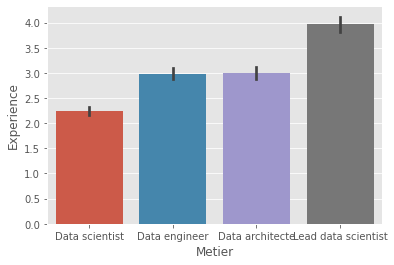

In [7]:
order_ = df.groupby(['Metier'])['Experience'].mean().sort_values().index # Pour ordonner les barres
sb.barplot(x='Metier', y = 'Experience', data = df, estimator=np.mean, order=order_)

### 6) Transformer la variable continue 'Experience' en une nouvelle variable catégorielle 'Exp_label' à 4 modalités: débutant, confirmé, avancé et expert
- Veuillez expliquer votre choix du règle de transformation.  

In [8]:
cut_labels = [
        'débutant', 'confirme', 'avance', 'expert'
        ]
cut_bins = [0.0, 2.0, 5.0, 10.0,df['Experience'].max()] # 0-2 'debutant', 2-5 'confirmé', 5-10 'avancé', plus de 10 'expert'
df['Exp_label'] = pd.cut(df['Experience'], bins=cut_bins,
                         labels=cut_labels,
                         include_lowest=True)

df['Exp_label'].value_counts() # Verification des effectifs au sein de chaque groupe crée

débutant    4842
confirme    3596
avance       861
expert       241
Name: Exp_label, dtype: int64

### 7) Quelles sont les 5 technologies les plus utilisées? Faites un graphique

In [9]:
# Création de plusieurs colonnes, avec une technologie par colonne
df_= df['Technologies'].str.split('/', expand=True)

# Création d'un dataFrame ayant comme index les différentes technologies et une colonne contenant la nombre de fois 
# où la technologie est utilisée
dataframe = []
for i in range(7):
    dataframe.append(pd.DataFrame({'Outils' : pd.Series(df_[i].value_counts()).index, 
                    'n_utilisation' : pd.Series(df_[i].value_counts())}))
    
# Récupération de tous les outils disponibles au niveau de la variable 'Technologies' 
Outils = []
for i in range(len(dataframe)):
    Outils.append([*dataframe[i]['Outils']])
Outils = sum(Outils, [])
Outils = list(set(Outils))

# Merge des values_count de chaque outils sous forme d'un DataFrame
df_0 = pd.DataFrame({'Outils': Outils, 'col_init' : [0 for i in range(len(Outils))]}) #Initialisation du dataFrame                                                                     # contenant tous les outils sur sa colonne 'Outils'
for i in range(len(dataframe)):
    df_0 = df_0.merge(dataframe[i], on = 'Outils', how = 'left')

# Affichage du nombre d'utilisation de chaque outils
nb_utilisation = pd.DataFrame({'Nb_utilisation':df_0.sum(axis=1), 'Outils' : [*df_0['Outils']]})

print(f"Le tableau suivant donne les 5 outils les plus utilisés dans l'ordre : \n")
nb_utilisation.sort_values(by = ['Nb_utilisation'],  ascending=False)[0:5]

Le tableau suivant donne les 5 outils les plus utilisés dans l'ordre : 



,Nb_utilisation,Outils
14,6627.0,Python
30,4374.0,R
50,2581.0,SQL
52,1719.0,Java
40,1589.0,Hadoop


### 8) Réaliser une méthode de clustering non supervisée de votre choix pour faire apparaître 2 clusters que vous jugerez pertinents. Donnez les caractéristiques de chacun des clusters.
-  Justifier la performance de votre algorithme grace à une métrique.
-  Interpréter votre resultat.  

Nous allons enlever les valeurs manquantes de le base puisqu'elles représentent moins de 1% des données

On verifie s'il est nécessaire de garder la variable Ville

In [10]:
df['Ville'].value_counts()

Paris          2015
Lyon           1781
Marseille      1548
Toulouse        871
Lille           771
Bordeaux        692
Nantes          365
Rennes          360
Rouen           315
Strasbourg      309
Toulon          186
Nice            183
Grenoble         99
Montpellier      87
Name: Ville, dtype: int64

Nous constatons que la variables 'Ville' présente plusieurs modalités et l'effectif de ces modalités ne sont pas équilibrés. Cette même analyse est faite sur la variable Entreprise.
Donc ces deux variables ne seront pas considérées dans notre modèle.

Nous allons créer 5 variables dichotomiques portant sur les 5 top technologies utilisées.
Exemple, la variable python contient '1' si l'individus utilise Python, '0' sinon.

In [11]:
# Création des 5 variables 
var_tech = [
    'Python', 'R', 'SQL', 'Java', 'Hadoop'
    ]
for tech in var_tech :
    df[tech] =  0
    df.loc[df['Technologies'].str.contains(tech, case=True), tech] = 1

# Garder le dataset pour la dernière question
df_class = df
df.head()

,Entreprise,Metier,Technologies,Diplome,Experience,Ville,Exp_label,Python,R,SQL,Java,Hadoop
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.0,Paris,débutant,1,0,0,0,0
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.0,Marseille,confirme,1,0,0,1,0
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.0,Nantes,confirme,1,1,1,0,0
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.5,Marseille,débutant,1,0,0,1,0
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,2.0,Bordeaux,débutant,1,0,0,0,0


In [12]:
# Préparation du dataset pour le clustering
df_clus = df.dropna()
print(f"Pourcentage de données restantes : {round(df_clus.shape[0]/len(df)*100,2)}%")

# Suppression de variables qui ne seront pas considérées
var_ = ['Ville', 'Experience', 'Entreprise', 'Technologies']
df_clus = df_clus.drop(columns = var_)

# Encodage des variables catégorielles en type numéric 
var = ['Diplome', 'Metier', 'Exp_label']
df_demmies = pd.get_dummies(df_clus[var])
df_clus = df_clus.drop(columns = var, axis=1)
df_clus = pd.concat([df_demmies, df_clus], axis=1)

Pourcentage de données restantes : 99.19%


In [13]:
# Application de l'approche KMEANS pour trouver les deux clusters
kmeans = KMeans(n_clusters= 2, n_init = 20, random_state=1).fit(df_clus)
labels =  kmeans.labels_

# Distribution des clusters
print(f'Distribution des clusters \n {pd.Series(labels).value_counts()}')
print(f'Indice de silhouette : {round(silhouette_score(df_clus, labels, random_state=100), 4)}')

Distribution des clusters 
 1    5009
0    4495
dtype: int64
Indice de silhouette : 0.1903


Nous avons obtenu un score pas assez satisfaisant mais qui reste positive puisque l'indice silhouette prend ses valeurs entre 1 et -1

### Cractérisation des clusters

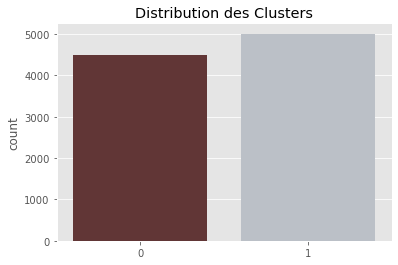

In [14]:
plt.figure()
pal = ["#682F2F","#B9C0C9"]
pl = sb.countplot(labels, palette= pal)
pl.set_title("Distribution des Clusters")
plt.show()

Nous avons obtenu deux classes assez équilibrées

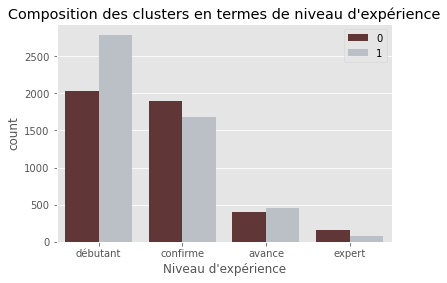

In [15]:
df_clus = df.dropna()

plt.figure()
pl = sb.countplot(df_clus['Exp_label'], hue = labels, palette = pal)
pl.set_title("Composition des clusters en termes de niveau d'expérience")
pl.set_xlabel("Niveau d'expérience")
plt.show()

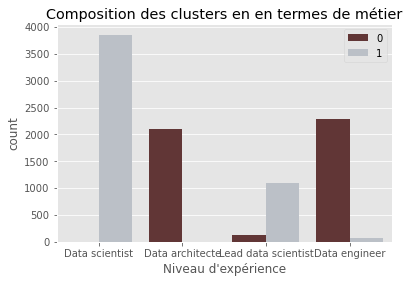

In [16]:
df_clus = df.dropna()

plt.figure()
pl = sb.countplot(df_clus['Metier'], hue = labels, palette = pal)
pl.set_title("Composition des clusters en en termes de métier")
pl.set_xlabel("Niveau d'expérience")
plt.show()

On peut nettement constater que la classe '1' est majoritairement composée par les data scientists ou et Lead data scientists alors que la classe '0' est majoritairement composée par des data architect et data engineer.

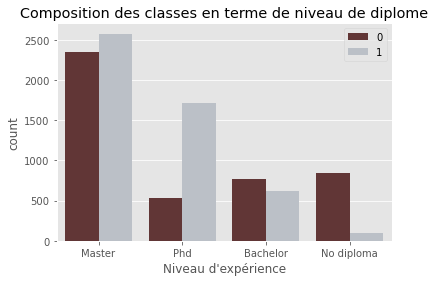

In [17]:
df_clus = df.dropna()

plt.figure()
pl = sb.countplot(df_clus['Diplome'], hue = labels, palette = pal)
pl.set_title("Composition des classes en terme de niveau de diplome")
pl.set_xlabel("Niveau d'expérience")
plt.show()

### 9) Réaliser la prédiction des métiers manquants dans la base de données par l'algorithme de votre choix
-  Justifier la performance de votre algorithme grace à une métrique.
-  Interpréter votre resultat.  

On va reprendre le dataset déjà préparé lors de notre clustering

In [18]:
df_class.head()

,Entreprise,Metier,Technologies,Diplome,Experience,Ville,Exp_label,Python,R,SQL,Java,Hadoop
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.0,Paris,débutant,1,0,0,0,0
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.0,Marseille,confirme,1,0,0,1,0
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.0,Nantes,confirme,1,1,1,0,0
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.5,Marseille,débutant,1,0,0,1,0
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,2.0,Bordeaux,débutant,1,0,0,0,0


In [19]:
#Suppression des variables 'Villes', 'Technologies' et experience
df_class = df_class.drop(columns = ['Technologies', 'Ville', 'Experience', 'Entreprise'], axis=1)

# Encodage des variables catégorielle de types numéric 'Diplome' 'Expe_label' pour l'apprentissage
var = ['Diplome', 'Exp_label']
df_demmies = pd.get_dummies(df_class[var])
df_class = df_class.drop(columns = var, axis=1)
df_class = pd.concat([df_demmies, df_class], axis=1)
df_class.head()

,Diplome_Bachelor,Diplome_Master,Diplome_No diploma,Diplome_Phd,Exp_label_débutant,Exp_label_confirme,Exp_label_avance,Exp_label_expert,Metier,Python,R,SQL,Java,Hadoop
0,0,1,0,0,1,0,0,0,Data scientist,1,0,0,0,0
1,0,1,0,0,0,1,0,0,Data architecte,1,0,0,1,0
2,0,1,0,0,0,1,0,0,Lead data scientist,1,1,1,0,0
3,0,1,0,0,1,0,0,0,Data scientist,1,0,0,1,0
4,0,0,0,1,1,0,0,0,Data scientist,1,0,0,0,0


In [20]:
#Séparation du dataset en deux partie : train_test et to_predict
df_to_pred = df_class[df_class['Metier'].isna()]
df_train_test = df_class[~(df_class['Metier'].isna())]
print(f"Dimensions du dataset qui servira dans l'apprentissag et le test: {df_train_test.shape}")
print(f"Dimensions du dataset qui servira dans la prediction : {df_to_pred.shape}")

# Encodage de la variable cyble Metier en numeric
label = { 'Data scientist' : 0 , 'Data engineer': 1,
         'Data architecte' : 2, 'Lead data scientist' : 3}
df_train_test.Metier = df_train_test.Metier.map(label)

#Recupération de X et y
X, y = df_train_test.loc[:, df_train_test.columns != 'Metier'], df_train_test.Metier

print(f"Dimension de X : {X.shape}")
print(f"Dimension de y : {y.shape}")

Dimensions du dataset qui servira dans l'apprentissag et le test: (9563, 14)
Dimensions du dataset qui servira dans la prediction : (19, 14)
Dimension de X : (9563, 13)
Dimension de y : (9563,)


In [21]:
# Séparation du dataset en données d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 12)

print(f"Dimensions de X_train : {X_train.shape}")
print(f"Dimensions de y_train : {X_train.shape}")
print(f"Dimensions de X_test : {X_test.shape}")
print(f"Dimensions de y_test : {y_test.shape}")

Dimensions de X_train : (7172, 13)
Dimensions de y_train : (7172, 13)
Dimensions de X_test : (2391, 13)
Dimensions de y_test : (2391,)


In [22]:
# Verifier le score avec une dummy model
dc = DummyClassifier().fit(X_train, y_train)
dc.score(X_test, y_test)

0.2915098285236303

In [23]:
# Nous allons appliquers une regression Logistiques qui est approche classique en apprentissage supervisé
# Nous chercherons les paramètres qui donnent le meilleurs score
params = {
    "C":np.logspace(-3,3,7),
    "penalty" : ["l2", "l1", "none"],
}

lc = LogisticRegression(random_state= 0, max_iter= 1000)
lc_cv = GridSearchCV(lc,params)
lc_cv.fit(X_train, y_train)

# Comme mesure de performance nous utilisons
# l'accuracy qui est une montre qui donne la capacité préditive du modèle à partir des données tests.
print(f"Selection des hpyerparametres :(meilleurs parameters) {lc_cv.best_params_}")
print(f"Accuracy : {lc_cv.best_score_}")


#model = LogisticRegression().fit(X_train, y_train)
#model.score(X_test, y_test)


Selection des hpyerparametres :(meilleurs parameters) {'C': 1.0, 'penalty': 'l2'}
Accuracy : 0.6331585827513984


### Prédiction des métiers manquantes

In [24]:
df_to_pred.Metier = lc_cv.predict(df_to_pred.loc[:, df_to_pred.columns != 'Metier'])

# Decodage de la variable cyble Metier en numeric
label_d = { 0: 'Data scientist', 1: 'Data engineer',
         2: 'Data architecte', 3 : 'Lead data scientist'}
df_to_pred.Metier = df_to_pred.Metier.map(label_d)
df_to_pred.Metier.value_counts()

Data scientist         11
Data architecte         5
Lead data scientist     2
Data engineer           1
Name: Metier, dtype: int64

#### A 63% nous avons prédit les métiers qui n'étaient pas renseignés